<a href="https://colab.research.google.com/github/chanidapa14092547/229352-stat/blob/main/Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

[Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/)

In [1]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [3]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [5]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [6]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [7]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

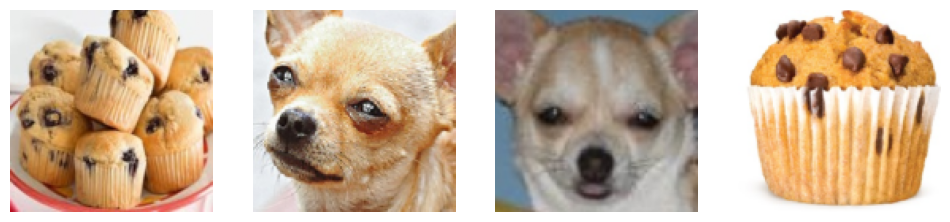

tensor([1, 0, 0, 1])


In [8]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  

[Linear layer in Pytorch](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)

[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [10]:
class SimpleLogisticRegression(nn.Module):
    def __init__(self):
        super(SimpleLogisticRegression, self).__init__()
        # Input images are 3x128x128. Flatten them to 3 * 128 * 128 features.
        self.flatten = nn.Flatten()
        # A single linear layer for logistic regression
        # Output 2 logits for CrossEntropyLoss (one for each class)
        self.linear = nn.Linear(3 * 128 * 128, 2)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [11]:
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()

#### Manually setting initial weights to zero for demonstration

In [12]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [14]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [15]:
learning_rate = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [16]:
for batch_idx, (X, y) in enumerate(train_loader):
    print(f"Minibatch {batch_idx + 1}:")
    print(f"  Features shape: {X.shape}")  # (batch_size, channel, height, weight)
    print(f"  Labels shape: {y.shape}")
    # Break after the first batch to demonstrate
    break

Minibatch 1:
  Features shape: torch.Size([10, 3, 128, 128])
  Labels shape: torch.Size([10])


#### Make a prediction on the minibatch (Forward pass)

In [18]:
y_hat = model(X)

#### Calculate the loss function

In [22]:
loss = criterion(y_hat, y)

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [20]:
loss.backward()

#### Calculate the gradient (Backward pass)

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [21]:
optimizer.step()
optimizer.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [24]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

In [28]:
print(train_losses)
print(val_losses)

[13.815511703491211, 10.217849731445312, 25.882396697998047, 21.00075912475586, 16.078081130981445, 23.375282287597656, 52.057891845703125, 82.08610534667969, 12.532058715820312, 34.04851531982422, 118.226806640625, 4.496382713317871, 72.87950134277344, 36.25703811645508, 72.1324691772461, 117.3800277709961, 81.21575927734375, 157.9591827392578, 85.59921264648438, 3.5523738915799186e-05, 150.58602905273438, 264.7169189453125, 157.48631286621094, 67.55644989013672, 77.47099304199219, 259.89459228515625, 196.25315856933594, 34.86199951171875, 98.70974731445312, 16.77173614501953, 41.56266784667969, 367.13507080078125, 687.6807861328125, 194.77294921875, 150.59490966796875, 90.90835571289062, 141.6720733642578, 92.41217041015625, 96.93042755126953, 121.80744934082031, 496.78778076171875, 261.565673828125, 405.32476806640625, 294.8539123535156, -0.0, 254.6444091796875, 5.632743835449219, 154.54818725585938, 152.97698974609375, 28.042390823364258, 179.2917022705078, 242.69589233398438, 113.

#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

In [30]:
model = MultiLayerPerceptron()
criterion = nn.CrossEntropyLoss()

# Using AdamW as it's generally a good default, as used earlier in the notebook
# We will start with a learning rate of 1e-3, as per the exercise.
learning_rate = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Manually setting initial weights to zero for demonstration
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

num_epochs = 10 # Set a number of epochs for training

for epoch in range(num_epochs):
  model.train() # Set model to training mode
  epoch_train_losses = []
  for X, y in train_loader:
    optimizer.zero_grad() # Zero the gradients at the start of each batch
    y_hat = model(X)
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()
    epoch_train_losses.append(loss.item())
  train_losses.append(np.mean(epoch_train_losses))

  model.eval() # Set model to evaluation mode
  epoch_val_losses = []
  with torch.no_grad():
    for X, y in val_loader:
      y_hat = model(X)
      val_loss = criterion(y_hat, y)
      epoch_val_losses.append(val_loss.item())
  val_losses.append(np.mean(epoch_val_losses))

  print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title(f'Training and Validation Loss per Epoch (LR = {learning_rate})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/10, Train Loss: 0.6931, Val Loss: 0.6936
Epoch 2/10, Train Loss: 0.6924, Val Loss: 0.6940
Epoch 3/10, Train Loss: 0.6918, Val Loss: 0.6942
Epoch 4/10, Train Loss: 0.6914, Val Loss: 0.6946
Epoch 5/10, Train Loss: 0.6909, Val Loss: 0.6951


KeyboardInterrupt: 

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [27]:
# Use this code to calculate test accuracy
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X)
  y_hat = y_hat[:, 0]
  y_hat = (y_hat > 0.5).float()  # the predictions
  ##TODO: compute accuracy


**1**

In [31]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super(MultiLayerPerceptron, self).__init__()
        self.flatten = nn.Flatten()
        # Input is 3 * 128 * 128 = 49152 features
        self.hidden1 = nn.Linear(3 * 128 * 128, 1024)
        self.relu1 = nn.ReLU()
        self.hidden2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.hidden3 = nn.Linear(512, 256)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(256, 2)  # 2 classes: Chihuahua or Muffin

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden1(x)
        x = self.relu1(x)
        x = self.hidden2(x)
        x = self.relu2(x)
        x = self.hidden3(x)
        x = self.relu3(x)
        x = self.output_layer(x)
        return x

**2**


--- Training with Learning Rate: 0.01 ---
Epoch 1/20, Train Loss: 0.6901, Val Loss: 0.6982
Epoch 2/20, Train Loss: 0.6892, Val Loss: 0.7025
Epoch 3/20, Train Loss: 0.6847, Val Loss: 0.7034
Epoch 4/20, Train Loss: 0.6863, Val Loss: 0.7064
Epoch 5/20, Train Loss: 0.6835, Val Loss: 0.7074
Epoch 6/20, Train Loss: 0.6895, Val Loss: 0.7109
Epoch 7/20, Train Loss: 0.6832, Val Loss: 0.7098
Epoch 8/20, Train Loss: 0.6844, Val Loss: 0.7117
Epoch 9/20, Train Loss: 0.6847, Val Loss: 0.7114
Epoch 10/20, Train Loss: 0.6861, Val Loss: 0.7118
Epoch 11/20, Train Loss: 0.6849, Val Loss: 0.7141
Epoch 12/20, Train Loss: 0.6898, Val Loss: 0.7137
Epoch 13/20, Train Loss: 0.6883, Val Loss: 0.7111
Epoch 14/20, Train Loss: 0.6869, Val Loss: 0.7090
Epoch 15/20, Train Loss: 0.6864, Val Loss: 0.7107
Epoch 16/20, Train Loss: 0.6896, Val Loss: 0.7110
Epoch 17/20, Train Loss: 0.6836, Val Loss: 0.7087
Epoch 18/20, Train Loss: 0.6860, Val Loss: 0.7091
Epoch 19/20, Train Loss: 0.6861, Val Loss: 0.7096
Epoch 20/20, Tra

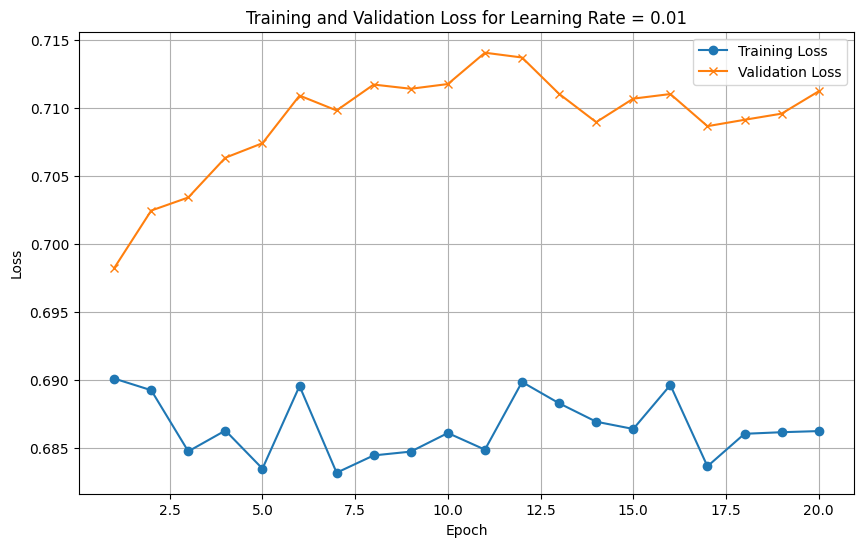

Final Training Loss (LR=0.01): 0.6862
Final Validation Loss (LR=0.01): 0.7112

--- Training with Learning Rate: 0.001 ---
Epoch 1/20, Train Loss: 0.6932, Val Loss: 0.6932
Epoch 2/20, Train Loss: 0.6926, Val Loss: 0.6937
Epoch 3/20, Train Loss: 0.6920, Val Loss: 0.6941
Epoch 4/20, Train Loss: 0.6918, Val Loss: 0.6945
Epoch 5/20, Train Loss: 0.6916, Val Loss: 0.6947
Epoch 6/20, Train Loss: 0.6917, Val Loss: 0.6951
Epoch 7/20, Train Loss: 0.6905, Val Loss: 0.6953
Epoch 8/20, Train Loss: 0.6897, Val Loss: 0.6954
Epoch 9/20, Train Loss: 0.6904, Val Loss: 0.6959
Epoch 10/20, Train Loss: 0.6892, Val Loss: 0.6962
Epoch 11/20, Train Loss: 0.6899, Val Loss: 0.6966
Epoch 12/20, Train Loss: 0.6911, Val Loss: 0.6970
Epoch 13/20, Train Loss: 0.6893, Val Loss: 0.6971
Epoch 14/20, Train Loss: 0.6887, Val Loss: 0.6974
Epoch 15/20, Train Loss: 0.6879, Val Loss: 0.6977
Epoch 16/20, Train Loss: 0.6884, Val Loss: 0.6981
Epoch 17/20, Train Loss: 0.6873, Val Loss: 0.6983
Epoch 18/20, Train Loss: 0.6871, Val 

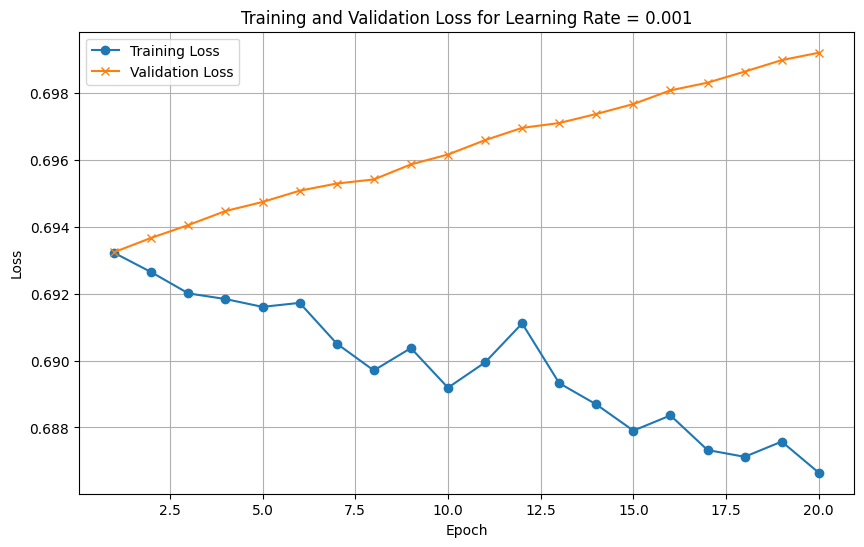

Final Training Loss (LR=0.001): 0.6866
Final Validation Loss (LR=0.001): 0.6992

--- Training with Learning Rate: 0.0001 ---
Epoch 1/20, Train Loss: 0.6931, Val Loss: 0.6932
Epoch 2/20, Train Loss: 0.6931, Val Loss: 0.6932
Epoch 3/20, Train Loss: 0.6930, Val Loss: 0.6932
Epoch 4/20, Train Loss: 0.6930, Val Loss: 0.6933
Epoch 5/20, Train Loss: 0.6930, Val Loss: 0.6933
Epoch 6/20, Train Loss: 0.6929, Val Loss: 0.6933
Epoch 7/20, Train Loss: 0.6929, Val Loss: 0.6934
Epoch 8/20, Train Loss: 0.6928, Val Loss: 0.6934
Epoch 9/20, Train Loss: 0.6929, Val Loss: 0.6935
Epoch 10/20, Train Loss: 0.6927, Val Loss: 0.6935
Epoch 11/20, Train Loss: 0.6926, Val Loss: 0.6935
Epoch 12/20, Train Loss: 0.6925, Val Loss: 0.6935
Epoch 13/20, Train Loss: 0.6927, Val Loss: 0.6936
Epoch 14/20, Train Loss: 0.6925, Val Loss: 0.6936
Epoch 15/20, Train Loss: 0.6923, Val Loss: 0.6936
Epoch 16/20, Train Loss: 0.6925, Val Loss: 0.6937
Epoch 17/20, Train Loss: 0.6925, Val Loss: 0.6937
Epoch 18/20, Train Loss: 0.6925, V

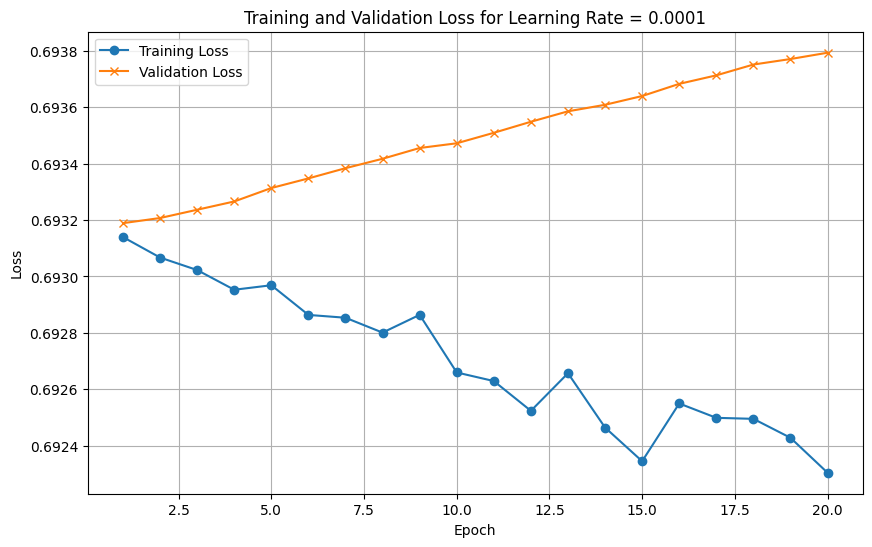

Final Training Loss (LR=0.0001): 0.6923
Final Validation Loss (LR=0.0001): 0.6938

--- Training with Learning Rate: 1e-05 ---
Epoch 1/20, Train Loss: 0.6932, Val Loss: 0.6931
Epoch 2/20, Train Loss: 0.6931, Val Loss: 0.6931
Epoch 3/20, Train Loss: 0.6931, Val Loss: 0.6932
Epoch 4/20, Train Loss: 0.6931, Val Loss: 0.6932
Epoch 5/20, Train Loss: 0.6931, Val Loss: 0.6932
Epoch 6/20, Train Loss: 0.6931, Val Loss: 0.6932
Epoch 7/20, Train Loss: 0.6931, Val Loss: 0.6932
Epoch 8/20, Train Loss: 0.6931, Val Loss: 0.6932
Epoch 9/20, Train Loss: 0.6931, Val Loss: 0.6932
Epoch 10/20, Train Loss: 0.6931, Val Loss: 0.6932
Epoch 11/20, Train Loss: 0.6931, Val Loss: 0.6932
Epoch 12/20, Train Loss: 0.6931, Val Loss: 0.6932
Epoch 13/20, Train Loss: 0.6931, Val Loss: 0.6932
Epoch 14/20, Train Loss: 0.6931, Val Loss: 0.6932
Epoch 15/20, Train Loss: 0.6931, Val Loss: 0.6932
Epoch 16/20, Train Loss: 0.6931, Val Loss: 0.6932
Epoch 17/20, Train Loss: 0.6931, Val Loss: 0.6932
Epoch 18/20, Train Loss: 0.6931, 

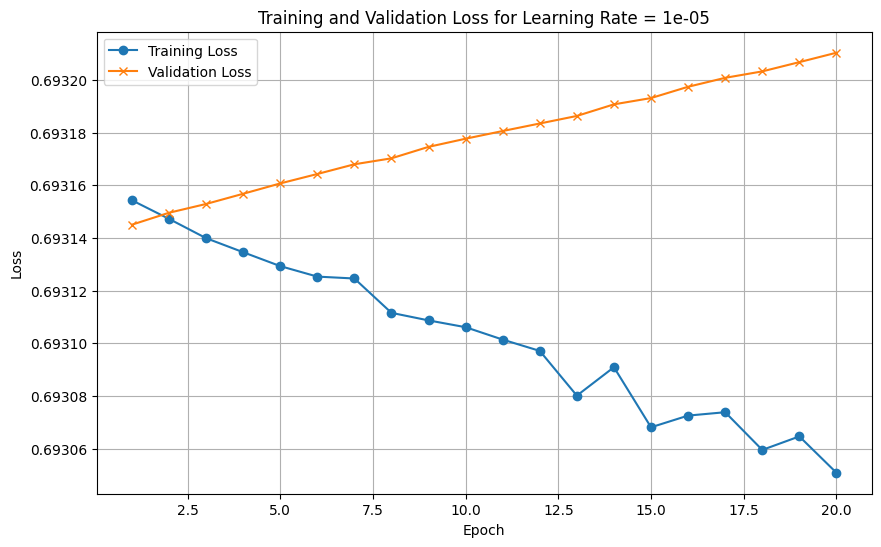

Final Training Loss (LR=1e-05): 0.6931
Final Validation Loss (LR=1e-05): 0.6932


In [32]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
num_epochs = 20

all_results = {}

for lr in learning_rates:
    print(f"\n--- Training with Learning Rate: {lr} ---")

    # a. Initialize a new instance of the MultiLayerPerceptron model.
    model = MultiLayerPerceptron()

    # b. Initialize the CrossEntropyLoss criterion.
    criterion = nn.CrossEntropyLoss()

    # c. Initialize the AdamW optimizer, passing the new model's parameters and the current learning rate.
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # d. Reset the weights and biases of the new model to zero.
    with torch.no_grad():
        for layer in model.modules():
            if isinstance(layer, nn.Linear):
                layer.weight.zero_()
                layer.bias.zero_()

    # e. Create empty lists train_losses_lr and val_losses_lr
    train_losses_lr = []
    val_losses_lr = []

    # f. Start an inner loop for training the model for the specified num_epochs
    for epoch in range(num_epochs):
        # i. Set the model to training mode
        model.train()
        # ii. Create an empty list epoch_train_losses.
        epoch_train_losses = []
        # iii. Iterate through train_loader for each batch (X, y):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()  # Zero the optimizer's gradients.
            y_hat = model(X_batch)  # Perform a forward pass
            loss = criterion(y_hat, y_batch)  # Calculate the loss
            loss.backward()  # Perform a backward pass
            optimizer.step()  # Update model weights
            epoch_train_losses.append(loss.item()) # Append loss.item() to epoch_train_losses.

        # iv. Calculate the mean of epoch_train_losses and append it to train_losses_lr.
        train_losses_lr.append(np.mean(epoch_train_losses))

        # v. Set the model to evaluation mode
        model.eval()
        # vi. Create an empty list epoch_val_losses.
        epoch_val_losses = []
        # vii. Use with torch.no_grad(): context.
        with torch.no_grad():
            # viii. Iterate through val_loader for each batch (X, y):
            for X_batch, y_batch in val_loader:
                y_hat = model(X_batch)  # Perform a forward pass
                val_loss = criterion(y_hat, y_batch)  # Calculate the validation loss
                epoch_val_losses.append(val_loss.item()) # Append val_loss.item() to epoch_val_losses.

        # ix. Calculate the mean of epoch_val_losses and append it to val_losses_lr.
        val_losses_lr.append(np.mean(epoch_val_losses))

        # x. Print the current epoch number, average training loss, and average validation loss.
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses_lr[-1]:.4f}, Val Loss: {val_losses_lr[-1]:.4f}")

    # g. After the training loop for the current learning rate, plot the losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses_lr, marker='o', label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses_lr, marker='x', label='Validation Loss')
    plt.title(f'Training and Validation Loss for Learning Rate = {lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # h. Print the final training loss and final validation loss for the current learning rate.
    print(f"Final Training Loss (LR={lr}): {train_losses_lr[-1]:.4f}")
    print(f"Final Validation Loss (LR={lr}): {val_losses_lr[-1]:.4f}")

    all_results[lr] = {'train_losses': train_losses_lr, 'val_losses': val_losses_lr}

**3**


--- Training the best model with Learning Rate: 0.001 ---
Epoch 1/20, Train Loss: 0.6928, Val Loss: 0.6936
Epoch 2/20, Train Loss: 0.6920, Val Loss: 0.6940
Epoch 3/20, Train Loss: 0.6917, Val Loss: 0.6944
Epoch 4/20, Train Loss: 0.6916, Val Loss: 0.6949
Epoch 5/20, Train Loss: 0.6906, Val Loss: 0.6952
Epoch 6/20, Train Loss: 0.6903, Val Loss: 0.6956
Epoch 7/20, Train Loss: 0.6907, Val Loss: 0.6960
Epoch 8/20, Train Loss: 0.6901, Val Loss: 0.6965
Epoch 9/20, Train Loss: 0.6892, Val Loss: 0.6967
Epoch 10/20, Train Loss: 0.6884, Val Loss: 0.6970
Epoch 11/20, Train Loss: 0.6886, Val Loss: 0.6974
Epoch 12/20, Train Loss: 0.6897, Val Loss: 0.6980
Epoch 13/20, Train Loss: 0.6881, Val Loss: 0.6983
Epoch 14/20, Train Loss: 0.6886, Val Loss: 0.6987
Epoch 15/20, Train Loss: 0.6869, Val Loss: 0.6989
Epoch 16/20, Train Loss: 0.6889, Val Loss: 0.6993
Epoch 17/20, Train Loss: 0.6880, Val Loss: 0.6997
Epoch 18/20, Train Loss: 0.6895, Val Loss: 0.6999
Epoch 19/20, Train Loss: 0.6877, Val Loss: 0.7001


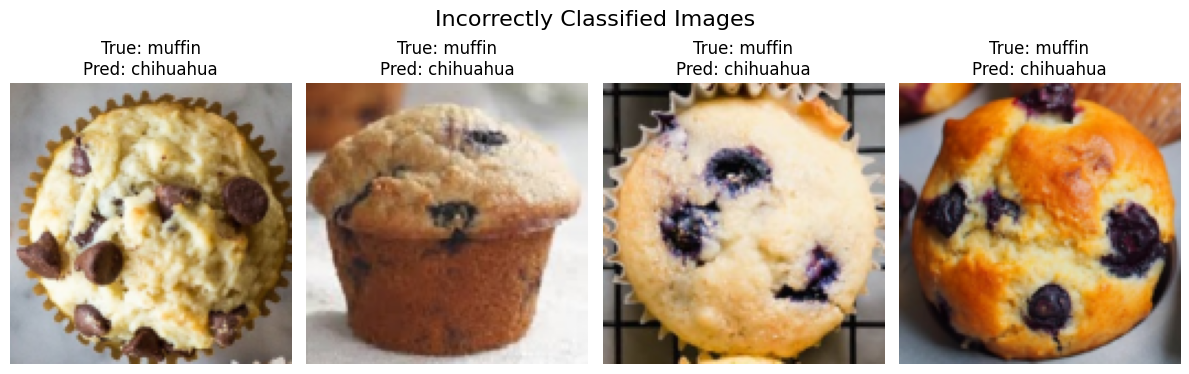

In [33]:
# Re-train the model with the best learning rate (1e-3) identified in the previous analysis
best_learning_rate = 1e-3
num_epochs = 20 # Using the same number of epochs as in the analysis

print(f"\n--- Training the best model with Learning Rate: {best_learning_rate} ---")

best_model = MultiLayerPerceptron()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(best_model.parameters(), lr=best_learning_rate)

# Reset weights to zero for consistency with previous training runs
with torch.no_grad():
    for layer in best_model.modules():
        if isinstance(layer, nn.Linear):
            layer.weight.zero_()
            layer.bias.zero_()

for epoch in range(num_epochs):
    best_model.train()
    epoch_train_losses = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_hat = best_model(X_batch)
        loss = criterion(y_hat, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())

    best_model.eval()
    epoch_val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_hat = best_model(X_batch)
            val_loss = criterion(y_hat, y_batch)
            epoch_val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(epoch_train_losses):.4f}, Val Loss: {np.mean(epoch_val_losses):.4f}")

print(f"\n--- Evaluating the best model (LR={best_learning_rate}) on the test set ---")

# Use the retrained best_model for prediction and accuracy calculation
best_model.eval() # Set model to evaluation mode

correct_predictions = 0
total_predictions = 0
incorrect_images = []
incorrect_labels = []
incorrect_predictions_list = []

with torch.no_grad():
    for X_test, y_test in test_loader:
        # Forward pass
        y_hat_logits = best_model(X_test)
        # Convert logits to probabilities and then to predicted classes
        _, predicted = torch.max(y_hat_logits.data, 1)

        total_predictions += y_test.size(0)
        correct_predictions += (predicted == y_test).sum().item()

        # Collect incorrectly classified images
        incorrect_mask = (predicted != y_test)
        incorrect_indices = torch.nonzero(incorrect_mask, as_tuple=True)[0]

        for idx in incorrect_indices:
            if len(incorrect_images) < 4: # Collect up to 4 incorrect images
                incorrect_images.append(X_test[idx].cpu().numpy())
                incorrect_labels.append(y_test[idx].item())
                incorrect_predictions_list.append(predicted[idx].item())
            else:
                break
        if len(incorrect_images) >= 4:
            break

accuracy = 100 * correct_predictions / total_predictions
print(f'Accuracy of the best model on the test images: {accuracy:.2f}%')


# Visualize the first four incorrectly classified images
if len(incorrect_images) > 0:
    fig, axes = plt.subplots(1, min(4, len(incorrect_images)), figsize=(12, 4))
    fig.suptitle('Incorrectly Classified Images', fontsize=16)

    # Map class labels to names if known (e.g., 0: 'Chihuahua', 1: 'Muffin')
    class_names = dataset.classes # Assuming dataset.classes is available from ImageFolder

    for i in range(len(incorrect_images)):
        img = incorrect_images[i].transpose(1, 2, 0) # Convert from (C, H, W) to (H, W, C)
        axes[i].imshow(img)
        axes[i].set_title(f'True: {class_names[incorrect_labels[i]]}\nPred: {class_names[incorrect_predictions_list[i]]}')
        axes[i].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("No incorrectly classified images to display.")

**4**

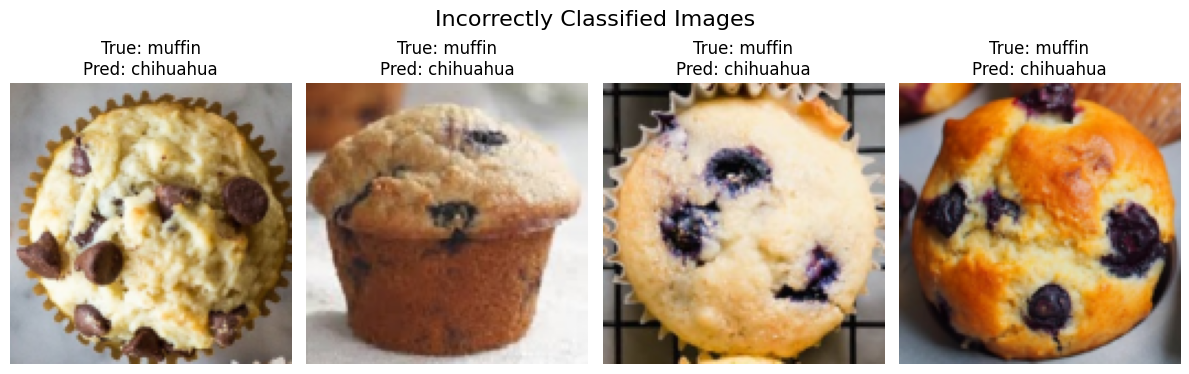

In [34]:
# The code to display incorrectly classified images was already executed in the previous cell (IMRJfdwTojQG).
# The output (plot) should be visible above.

# If you wish to re-run the display code:
if len(incorrect_images) > 0:
    fig, axes = plt.subplots(1, min(4, len(incorrect_images)), figsize=(12, 4))
    fig.suptitle('Incorrectly Classified Images', fontsize=16)

    class_names = dataset.classes

    for i in range(len(incorrect_images)):
        img = incorrect_images[i].transpose(1, 2, 0)
        axes[i].imshow(img)
        axes[i].set_title(f'True: {class_names[incorrect_labels[i]]}\nPred: {class_names[incorrect_predictions_list[i]]}')
        axes[i].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("No incorrectly classified images to display.")